<a href="https://colab.research.google.com/github/BioGeMT/DLforGenomics/blob/main/notebooks/One_hot_encoding_and_1D_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, we will go over two main concepts - one-hot encoding of data and 1D convolutional neural network. We will try this concept on an example of classifying DNA sequences, if they contain binding site of a particular miRNA, or not. We will go over steps of data prepareation, model preparation, model training and model evaluation.

# One-Hot Encoding in Neural Networks

## Introduction

In the world of machine learning and neural networks, we encounter two primary types of data:
- numerical, and
- categorical.

Numerical data, such as age or salary, inherently possesses mathematical meaning, while categorical data, like eye color or country, represents distinct groups or categories. To effectively use categorical data in neural networks, we often need to transform it into a numerical format, as neural networks inherently process numerical data. One common and effective transformation technique is one-hot encoding.

## Why Transform Categorical Data?
### Categorical Data and Neural Networks

Categorical data does not have a natural order or inherent numeric relationship. For instance, consider the categories 'cat', 'dog', and 'bird'. There is no numeric or ordinal relationship between these categories that a neural network can inherently understand. Therefore, we need to convert these categories into a format that allows the neural network to interpret and process them.

## Why Simple Enumeration is Not Enough
### Issues with Enumeration

A straightforward method might be to assign each category a unique integer (e.g., 'cat' = 1, 'dog' = 2, 'bird' = 3). However, this method is problematic for several reasons:

1. **Implicit Ordinal Relationship:** Assigning integers implies an ordinal relationship that doesn't exist (i.e., the network might infer that 'dog' is greater than 'cat').
2. **Distance Misinterpretation:** The network may misinterpret the numerical differences as meaningful distances (e.g., it might think 'bird' is closer to 'dog' than 'cat').

## One-Hot Encoding to the Rescue

One-hot encoding resolves these issues by creating a binary vector for each category. Each category is represented by a vector where one element is '1' (indicating the presence of that category) and all other elements are '0'.

### Example: One-Hot Encoding

Consider a categorical variable with three categories: 'cat', 'dog', and 'bird'. Using one-hot encoding, we represent these categories as:

    'cat' -> [1, 0, 0]
    'dog' -> [0, 1, 0]
    'bird' -> [0, 0, 1]

This method ensures that each category is equidistant from the others and that there is no implicit order.

### Example: One-Hot Encoding in Genomic Data

Genomic data, such as DNA or RNA sequences, consists of categorical variables representing nucleotides. DNA sequences, for example, are composed of four nucleotides: Adenine (A), Cytosine (C), Guanine (G), and Thymine (T). RNA sequences replace Thymine with Uracil (U).

Using one-hot encoding, we represent each nucleotide as a binary vector:
```
'A' -> [1, 0, 0, 0]
'C' -> [0, 1, 0, 0]
'G' -> [0, 0, 1, 0]
'T' -> [0, 0, 0, 1]
```
If we want to include Unknown nucleotide (N), we have to options:
- we can enlarge our alphabet and encode every nucleotide using 5 position:
```
'A' -> [1, 0, 0, 0, 0]
'C' -> [0, 1, 0, 0, 0]
'G' -> [0, 0, 1, 0, 0]
'T' -> [0, 0, 0, 1, 0]
'N' -> [0, 0, 0, 0, 1]
```
- or we can encode it as lack of infomation, using all-zero vector:
```
'A' -> [1, 0, 0, 0]
'C' -> [0, 1, 0, 0]
'G' -> [0, 0, 1, 0]
'T' -> [0, 0, 0, 1]
'N' -> [0, 0, 0, 0]
```

### Benefits of One-Hot Encoding in Neural Networks

1. **No Implicit Ordering:** Each category is treated equally without any implied order.
2. **Binary Representation:** The binary nature simplifies the network's learning process, as the presence or absence of a category is straightforward.
3. **Avoids Misinterpretation:** Prevents the network from misinterpreting categorical relationships as numeric distances.

## Conclusion

One-hot encoding is a crucial preprocessing step in preparing categorical data for neural networks. By converting categories into binary vectors, we preserve the categorical nature of the data and enable the neural network to process and learn from it effectively. This technique is especially useful in fields like genomics, where sequences of nucleotides can be efficiently encoded for computational analysis.

# Setup

## Imports

In [1]:
from tensorflow import keras as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, classification_report

## Downloads

In [2]:
!wget https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv -O miRNA_train_set.tsv

--2024-06-03 12:40:20--  https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101082 (99K) [text/plain]
Saving to: ‘miRNA_train_set.tsv’

miRNA_train_set.tsv 100%[===================>]  98.71K  --.-KB/s    in 0.01s   

2024-06-03 12:40:20 (7.16 MB/s) - ‘miRNA_train_set.tsv’ saved [101082/101082]



# Data preparation

In [3]:
df = pd.read_csv('miRNA_train_set.tsv', sep='\t')
df

,gene,label
0,AGCACTGCCGCCGGGGACTGCTCAGCAACCACACCGGCAGCCCGCG...,1
1,CTTCTCGGAGACGGTGCGCATCATCAACCGCAAGGTGAAGCCGCGG...,1
2,GGGCTGGGCAAAGAATGTGCAAAAGTCTTCTATGCTGCGGGTGCTA...,1
3,TCCACTAGAAGGCTGGGACAGCACCGGTGATTACTGTCTTTCCTGC...,1
4,AGTTCACAGGCTTTGTGGACATGTGTGTGCAGCATATCCCTTCTCC...,1
...,...,...
1902,TCTAAGCCATCCAGTGCCATCCTCGTCGCTGCAGCGACACACGCTC...,0
1903,AACCACGTCTCCTACTTTCCAAACCCATGGCAGTGTCCCTGCTCCA...,0
1904,ATTGAAGCCTGCCCATCCTCCCATGAGAGACTCTTGTTAGTCAACA...,0
1905,GCCAGCCCTACACTCGCCCGCGCCATGGCCTCTGTCTCCGAGCTCG...,0


In [4]:
def sequence_to_ohe(
        dataset,
        sequence_size,
        channel={
            'A': 0,
            'T': 1,
            'C': 2,
            'G': 3
        }
):
    """
    fun builds the one hot encoding numpy array of each
    sample sequence.

    paramenters:
    dataset = dataset of sequences to encode
    sequence_size = can corresponds to the
    length of the input sequences
    (if all the same) or an arbitrary number can be defined.
    channel = the coding of nucleotides.

    """

    # further processing is expecting list of sequences
    if isinstance(dataset, str):
        dataset = [dataset]

    samples_size = len(dataset)

    # structure, where we will hold one-hot encoded dataset
    # it is pre-filled with zeros
    # we will put 1s in positions of nucleotides
    ohe_dataset = np.zeros((samples_size, sequence_size, len(set(channel.values()))))

    for index, sequence in enumerate(dataset):
        for pos, nucleotide in enumerate(sequence):
            if nucleotide == 'N':
                continue
            ohe_dataset[index, pos, channel[nucleotide]] = 1

    return ohe_dataset

In [5]:
seq = df['gene'][:1][0]
seq_ohe = sequence_to_ohe(seq, 50)

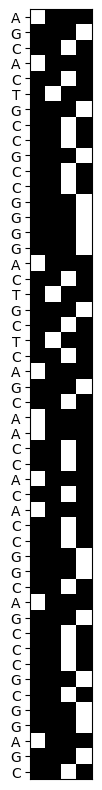

In [11]:
def plot_ohe(seq, seq_ohe):
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    ax.imshow(seq_ohe[0, :], cmap='gray')
    ax.set_yticks(range(len(seq)))
    ax.set_yticklabels(seq)
    ax.set_xticks([])
    ax.set_xticklabels([])
    plt.plot();

plot_ohe(seq, seq_ohe)

In [35]:
def encode_dataset_ohe(df, seq_col, label_col):

    # do not forget to shuffle your data so every batch will contain both positive and negative samples
    df = df.sample(frac=1, random_state=42)
    df.reset_index(inplace=True, drop=True)

    max_length = df[seq_col].map(len).max()
    ohe_samples = sequence_to_ohe(df[seq_col], max_length)
    labels = df[label_col]

    if ohe_samples.shape[0] != labels.shape[0]:
        print('sequence and label shapes are different, something went wrong...')

    print(
        'samples',
        ohe_samples.shape,
        '\nlabels',
        labels.shape
    )

    return ohe_samples, labels

In [36]:
samples_ohe, labels = encode_dataset_ohe(df, "gene", "label")

samples (1907, 50, 4) 
labels (1907,)


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
        samples_ohe, labels, test_size=0.2, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1525, 50, 4)
y_train: (1525,)
X_test: (382, 50, 4)
y_test: (382,)


# Convolution

We know that input data for our machine learning models use vectors. How can we represent image data as vectors? If we were to flatten a two-dimensional image into a single stream of numbers such that we could capture it as a vector, we lose some key relationships between the pixels, such as the distance between pixels representing the same object. In this case, we need to use a convolution.

A convolution combines information about local pixels such that pixels close to each other in an image are ”summarized” by a smaller set of pixels. This ”summarization” is done by ”sliding” a kernel across an image to output a final product for each position of the kernel.

![](https://courses.cs.washington.edu/courses/cse446/21au/sections/08/correlation.png)

![](https://miro.medium.com/v2/resize:fit:1280/0*LCLFmo82CFaAAvC_.gif)

Special kernels which have specific properties such as maintaining the same image, applying a box blur, sharpening the image, and detecting edges.

![](https://miro.medium.com/v2/resize:fit:1206/0*czWUfPtxU3CTg3SN.png)

# 1D Convolution

In 1D convolution, kernel slides in one dimension. This can be useful for processing data that have one dimension, such as time series, audio, text or genomic sequences.

![](https://i.imgur.com/5UQz1zI.jpg)

# Exercise: convolution to look for a ACT motif

In [21]:
seq_ohe[0][0:3]

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]])

In [26]:
# define ACT kernel
# 'A': 0,
# 'T': 1,
# 'C': 2,
# 'G': 3

# act_kernel = [
#     [?, ?, ?, ?],
#     [?, ?, ?, ?],
#     [?, ?, ?, ?]
# ]

def convolution(seq_ohe, kernel):

  features = []
  for index in range(seq_ohe.shape[1] - len(kernel) + 1):
    features.append(
        np.sum(np.multiply(seq_ohe[0][index:index + len(kernel)], kernel))
    )

  return features


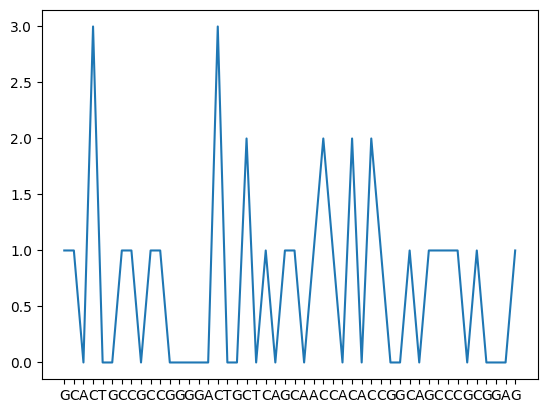

In [32]:
features = convolution(seq_ohe, act_kernel)

fig, ax = plt.subplots()
ax.plot(features)
ax.set_xticks(range(len(seq[1:-1])))
ax.set_xticklabels(seq[1:-1])
plt.show();

# Model preparation

Building the neural network requires configuring the layers of the model, then compiling the model.

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Conv1D` or `tf.keras.layers.Dense`, have parameters that are learned during training.

In [33]:
def get_model(
    sequence_size, channel,
    filters = 10,
    kernel_size = 6,
    strides = 1,
    dense_neurons = 10):

  model = tf.keras.Sequential([
    # first layer of 1D convolution
    tf.keras.layers.Conv1D(
      filters=filters, # the dimension of the output space (the number of filters in the convolution)
      kernel_size=kernel_size, # specifying the size of the convolution window
      strides=strides, # specifying the stride length of the convolution
      padding='same',
      data_format="channels_last",
      activation='relu', # activation function
      input_shape=(sequence_size, channel)
    ),

    # second layer of 1D convolution
    tf.keras.layers.Conv1D(
      filters=filters,
      kernel_size=kernel_size,
      strides=strides,
      padding='same',
      data_format="channels_last",
      activation='relu'
    ),

    # flatten layer to get 1D output
    tf.keras.layers.Flatten(),

    # dense layer
    tf.keras.layers.Dense(dense_neurons, activation="relu"),

    # output neuron producing prediction in the range <0, 1>
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  return model

The first layer in this network, `tf.keras.layers.Conv1D`, scans the input using 10 convolutional kernels of size (by default). Weight of kernels are used during training.

The second layer does the same, but on the output of the first layer. This allows for learning progresively more complicated patterns in deeper layers.

Example of features learned by kernels in the CNN trained on images:
![](https://twopointseven.github.io/images/features.png)

The third layer in this network, `tf.keras.layers.Flatten`, transforms the format of data from two-dimensional array (50 by 10) to a one-dimensional array (of 500). This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 10 nodes (or neurons). The second (and last) layer returns one number in the range `<0, 1>` representing a probability of positive class.

In [38]:
model = get_model(sequence_size = X_train.shape[1], channel = X_train.shape[2])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 10)            250       
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 10)            610       
                                                                 
 flatten (Flatten)           (None, 500)               0         
                                                                 
 dense (Dense)               (None, 10)                5010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 5881 (22.97 KB)
Trainable params: 5881 (22.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

  - **Optimizer** - This is how the model is updated based on the data it sees and its loss function.
  - **Loss function** - This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
  - **Metrics** - Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.


In [39]:
def compile_model(
      model,
      learning_rate = 0.001):

    optimizer = K.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [40]:
model = compile_model(model)

# Model training

To start training, call the `model.fit` method—so called because it "fits" the model to the training data.

In [41]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=15,
    validation_split=0.2
)

Epoch 1/15
39/39 [==============================] - 2s 13ms/step - loss: 0.6906 - accuracy: 0.5352 - val_loss: 0.6854 - val_accuracy: 0.5508
Epoch 2/15
39/39 [==============================] - 0s 8ms/step - loss: 0.6635 - accuracy: 0.6393 - val_loss: 0.6639 - val_accuracy: 0.5967
Epoch 3/15
39/39 [==============================] - 0s 7ms/step - loss: 0.6191 - accuracy: 0.6697 - val_loss: 0.6395 - val_accuracy: 0.6623
Epoch 4/15
39/39 [==============================] - 0s 7ms/step - loss: 0.5814 - accuracy: 0.7016 - val_loss: 0.6314 - val_accuracy: 0.6393
Epoch 5/15
39/39 [==============================] - 0s 8ms/step - loss: 0.5559 - accuracy: 0.7131 - val_loss: 0.6194 - val_accuracy: 0.6721
Epoch 6/15
39/39 [==============================] - 0s 7ms/step - loss: 0.5346 - accuracy: 0.7213 - val_loss: 0.6087 - val_accuracy: 0.7016
Epoch 7/15
39/39 [==============================] - 0s 7ms/step - loss: 0.5214 - accuracy: 0.7377 - val_loss: 0.6092 - val_accuracy: 0.6754
Epoch 8/15
39/39 [=

As the model trains, the loss and accuracy metrics are displayed.

We are also collecting them in the `history` variable that we can use for plotting the progress if training.

In [42]:
def plot_history(history):
    """
    fun plots history of the training of the model,
    accuracy and loss of the training and validation set

    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(epochs, acc)
    axes[0].plot(epochs, val_acc)
    axes[0].set_title('Accuracy')

    axes[1].plot(epochs, loss, label='Training')
    axes[1].plot(epochs, val_loss, label='Validation')
    axes[1].set_title('Loss')

    fig.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    fig.tight_layout()

    plt.show()

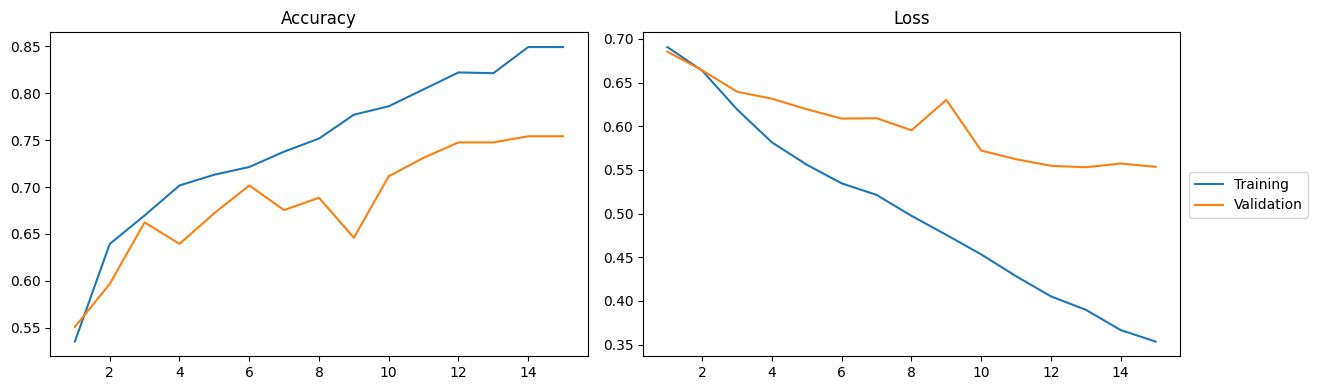

In [43]:
plot_history(history)

# Model evaluation

In [44]:
probs = model.predict(X_test)

12/12 [==============================] - 0s 2ms/step


In [45]:
probs[:10]

array([[0.97485554],
       [0.9817871 ],
       [0.86357665],
       [0.2642725 ],
       [0.5789562 ],
       [0.15340306],
       [0.34604138],
       [0.44238108],
       [0.04589703],
       [0.7570009 ]], dtype=float32)

In [46]:
preds = [0 if prob < 0.5 else 1 for prob in probs]
preds[:10]

[1, 1, 1, 0, 1, 0, 0, 0, 0, 1]

In [47]:
accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.693717277486911
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.64      0.69       205
           1       0.64      0.76      0.70       177

    accuracy                           0.69       382
   macro avg       0.70      0.70      0.69       382
weighted avg       0.70      0.69      0.69       382



In [48]:
def draw_precision_recall_curve(probs, labels):
    precision, recall, thresholds = precision_recall_curve(labels, preds)
    plt.plot(recall, precision, label='CNN model')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower center")
    plt.title('Precision recall curve')
    auc_precision_recall = auc(recall, precision)
    print("AUC-PR:", auc_precision_recall)
    plt.show()

AUC-PR: 0.7569291805748013


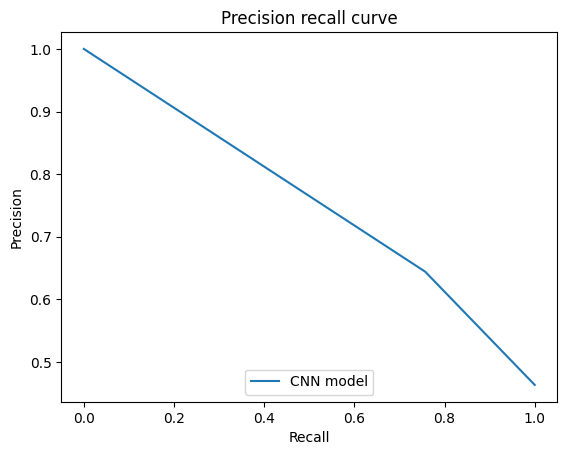

In [49]:
draw_precision_recall_curve(probs, y_test)

# Excercise: Manual hyper-parameter tuning

We were able to achieve accuracy above randon on a test set, but there seems to be a space for improvement.

A big part of ML/DL model development is hyper-parameter tuning. TensorFlow contains multiple way how to help with that. You can start by looking at [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner) or [Automated hyper-parameter tuning](https://www.tensorflow.org/decision_forests/tutorials/automatic_tuning_colab) tutorials.

But to get an initial idea what might works better and what worse, it can be an good idea to try few iterations of manual hyper-parameter tuning. You will choose values of hyper-parameters and you will observe how it changes model's performance.

In our code, there are several hyper-parameters and they are located in the following functions:

```python
model = get_model(...
model = compile_model(...
history = model.fit(...
```

Try several different combinations of hyper-parameters and observe changes in the model's performance.

## Bonus:

If you want, you can even try changing architecture of the model by changing it inside of a `get_model()` function. You can start by playing with adding/removing `Conv1D`, `Dense` and `Dropout` layers.
For the overview of all available layers, have a look at [TensorFlow tf.keras.layers documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers).